In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from pandarallel import pandarallel

pandarallel.initialize()

%matplotlib inline
%reload_ext nb_black

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>

In [2]:
df = pd.read_parquet("../data/data.parquet.gzip")

<IPython.core.display.Javascript object>

In [3]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount
0,2018-07-21 18:59:21.102761,Latvia,2018-04-20,2018-04-17,0.0,4400.0
1,2018-07-21 18:50:02.050224,Peru,2018-04-20,2018-04-20,0.0,4400.0
2,2018-07-21 18:22:00.561856,Peru,2018-04-20,2018-04-16,1.0,2640.0
3,2018-07-21 19:00:35.451683,China,2018-04-20,2018-04-20,2.0,3080.0
4,2015-05-21 18:56:29.671213,Peru,2018-04-20,2018-04-19,0.0,4400.0


<IPython.core.display.Javascript object>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285570 entries, 0 to 285569
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       285570 non-null  object        
 1   country_code    285570 non-null  object        
 2   last_order_ts   285570 non-null  object        
 3   first_order_ts  285570 non-null  datetime64[ns]
 4   total_orders    285570 non-null  object        
 5   voucher_amount  283839 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 13.1+ MB


<IPython.core.display.Javascript object>

In [5]:
df["total_orders"] = pd.to_numeric(df.total_orders)

<IPython.core.display.Javascript object>

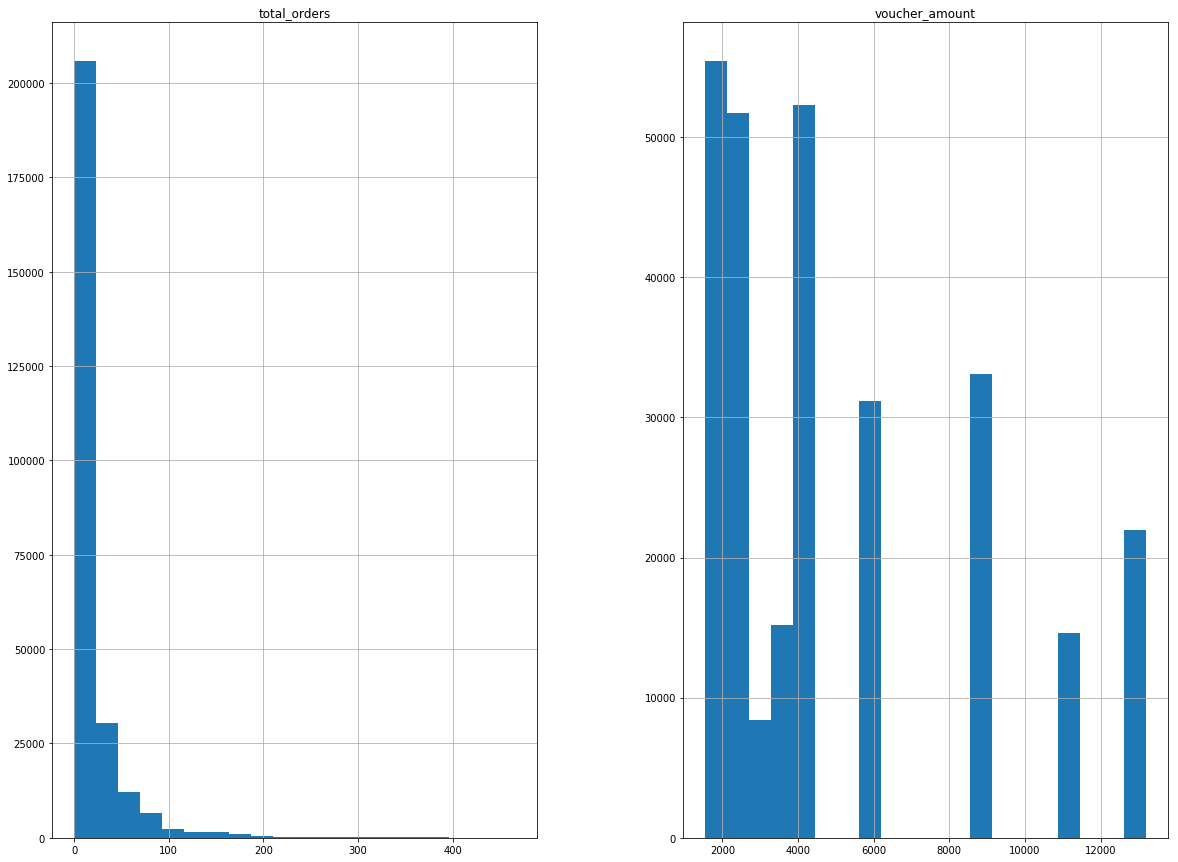

<IPython.core.display.Javascript object>

In [6]:
df.hist(bins=20, figsize=(20, 15))
plt.show()

In [7]:
df.voucher_amount.value_counts()

1760.0     52285
4400.0     52272
8800.0     33123
5720.0     31189
2200.0     28670
2640.0     23040
13200.0    21968
3520.0     15160
11000.0    14607
3080.0      8387
1540.0      3138
Name: voucher_amount, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df.corr()["voucher_amount"].sort_values(ascending=False)

voucher_amount    1.000000
total_orders     -0.016841
Name: voucher_amount, dtype: float64

<IPython.core.display.Javascript object>

### Create Fequent Segment

In [9]:
# bins = pd.IntervalIndex.from_tuples([(0, 4), (5, 13), (14, 37), (38, np.inf)])
bins = [0.0, 4.0, 13.0, 37.0, np.inf]
labels = ["0-4", "5-13", "13-37", "38-higher"]

<IPython.core.display.Javascript object>

In [10]:
df["total_orders_ranges"] = pd.cut(
    df["total_orders"], bins=bins, labels=labels, include_lowest=True
)

<IPython.core.display.Javascript object>

In [11]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,total_orders_ranges
0,2018-07-21 18:59:21.102761,Latvia,2018-04-20,2018-04-17,0.0,4400.0,0-4
1,2018-07-21 18:50:02.050224,Peru,2018-04-20,2018-04-20,0.0,4400.0,0-4
2,2018-07-21 18:22:00.561856,Peru,2018-04-20,2018-04-16,1.0,2640.0,0-4
3,2018-07-21 19:00:35.451683,China,2018-04-20,2018-04-20,2.0,3080.0,0-4
4,2015-05-21 18:56:29.671213,Peru,2018-04-20,2018-04-19,0.0,4400.0,0-4


<IPython.core.display.Javascript object>

In [12]:
one_hot_freq_segment = pd.get_dummies(df["total_orders_ranges"], prefix="freq")

<IPython.core.display.Javascript object>

In [13]:
df = df.drop("total_orders_ranges", axis=1)

<IPython.core.display.Javascript object>

In [14]:
df = df.join(one_hot_freq_segment)

<IPython.core.display.Javascript object>

In [15]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher
0,2018-07-21 18:59:21.102761,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0
1,2018-07-21 18:50:02.050224,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0
2,2018-07-21 18:22:00.561856,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0
3,2018-07-21 19:00:35.451683,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0
4,2015-05-21 18:56:29.671213,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0


<IPython.core.display.Javascript object>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285570 entries, 0 to 285569
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       285570 non-null  object        
 1   country_code    285570 non-null  object        
 2   last_order_ts   285570 non-null  object        
 3   first_order_ts  285570 non-null  datetime64[ns]
 4   total_orders    262725 non-null  float64       
 5   voucher_amount  283839 non-null  float64       
 6   freq_0-4        285570 non-null  uint8         
 7   freq_5-13       285570 non-null  uint8         
 8   freq_13-37      285570 non-null  uint8         
 9   freq_38-higher  285570 non-null  uint8         
dtypes: datetime64[ns](1), float64(2), object(3), uint8(4)
memory usage: 14.2+ MB


<IPython.core.display.Javascript object>

In [17]:
df.corr()["voucher_amount"].sort_values(ascending=False)

voucher_amount    1.000000
freq_0-4          0.023263
freq_5-13        -0.008318
freq_13-37       -0.010647
freq_38-higher   -0.014971
total_orders     -0.016841
Name: voucher_amount, dtype: float64

<IPython.core.display.Javascript object>

### Convert timestamp to datetime

In [18]:
df["timestamp"] = pd.to_datetime(df["timestamp"] ,format='%Y-%m-%d').dt.date
df["last_order_ts"] = pd.to_datetime(df["last_order_ts"], format='%Y-%m-%d')


<IPython.core.display.Javascript object>

In [19]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0
4,2015-05-21,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0


<IPython.core.display.Javascript object>

In [20]:
# It's improbable that the timestamp of the event is before the first or last order.
# In this case change the event timestamp to max of time stamp as it is a safe assumption,
# as the customer might be given the voucher as he hasn't returned back in some time.

# df[(df.timestamp < df.last_order_ts) | (df.timestamp < df.first_order_ts)][
#     "timestamp"
# ] = df.timestamp.max()

df.loc[
    (df.timestamp < df.last_order_ts) | (df.timestamp < df.first_order_ts), "timestamp"
] = df.timestamp.max()

<IPython.core.display.Javascript object>

In [21]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0


<IPython.core.display.Javascript object>

In [22]:
df["timestamp"] = pd.to_datetime(df["timestamp"])


<IPython.core.display.Javascript object>

### Create recency_segment_ranges

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285570 entries, 0 to 285569
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       285570 non-null  datetime64[ns]
 1   country_code    285570 non-null  object        
 2   last_order_ts   285570 non-null  datetime64[ns]
 3   first_order_ts  285570 non-null  datetime64[ns]
 4   total_orders    262725 non-null  float64       
 5   voucher_amount  283839 non-null  float64       
 6   freq_0-4        285570 non-null  uint8         
 7   freq_5-13       285570 non-null  uint8         
 8   freq_13-37      285570 non-null  uint8         
 9   freq_38-higher  285570 non-null  uint8         
dtypes: datetime64[ns](3), float64(2), object(1), uint8(4)
memory usage: 14.2+ MB


<IPython.core.display.Javascript object>

In [24]:
df["days_since_last_order"] = (df["timestamp"] - df["last_order_ts"]).dt.days

<IPython.core.display.Javascript object>

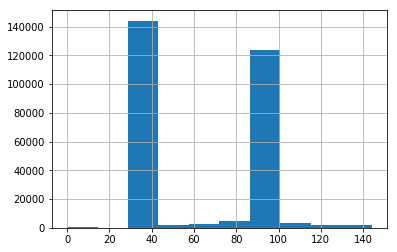

<IPython.core.display.Javascript object>

In [25]:
df["days_since_last_order"].hist()

#### Use median values in case of improbable last_order_ts

median_value = df.days_since_last_order.median()

df.loc[df["days_since_last_order"] < 0, "days_since_last_order"] = median_value

### Create Recency Segment

In [26]:
bins = [0.0, 30, 60, 90, 120, 180, np.inf]
labels = ["0-30", "30-60", "60-90", "90-120", "120-180", "180+"]

<IPython.core.display.Javascript object>

In [27]:
df["recency_segment_ranges"] = pd.cut(
    df["days_since_last_order"], bins=bins, labels=labels, include_lowest=True
)

<IPython.core.display.Javascript object>

In [28]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,days_since_last_order,recency_segment_ranges
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,92,90-120
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,92,90-120
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,92,90-120
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,92,90-120
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,102,90-120


<IPython.core.display.Javascript object>

In [29]:
one_hot_rec_segment = pd.get_dummies(df["recency_segment_ranges"], prefix="rec_segment")

<IPython.core.display.Javascript object>

In [30]:
df = df.join(one_hot_rec_segment)

<IPython.core.display.Javascript object>

df = df.drop("days_since_last_order", axis=1)

In [31]:
df.isna().sum()

timestamp                     0
country_code                  0
last_order_ts                 0
first_order_ts                0
total_orders              22845
voucher_amount             1731
freq_0-4                      0
freq_5-13                     0
freq_13-37                    0
freq_38-higher                0
days_since_last_order         0
recency_segment_ranges        0
rec_segment_0-30              0
rec_segment_30-60             0
rec_segment_60-90             0
rec_segment_90-120            0
rec_segment_120-180           0
rec_segment_180+              0
dtype: int64

<IPython.core.display.Javascript object>

In [32]:
df = df.dropna(how="any")

<IPython.core.display.Javascript object>

In [33]:
df.isna().sum()

timestamp                 0
country_code              0
last_order_ts             0
first_order_ts            0
total_orders              0
voucher_amount            0
freq_0-4                  0
freq_5-13                 0
freq_13-37                0
freq_38-higher            0
days_since_last_order     0
recency_segment_ranges    0
rec_segment_0-30          0
rec_segment_30-60         0
rec_segment_60-90         0
rec_segment_90-120        0
rec_segment_120-180       0
rec_segment_180+          0
dtype: int64

<IPython.core.display.Javascript object>

In [34]:
df = df.drop("recency_segment_ranges", axis=1)

<IPython.core.display.Javascript object>

In [35]:
df.corr()["voucher_amount"].sort_values(ascending=False)

voucher_amount           1.000000
rec_segment_90-120       0.125608
days_since_last_order    0.124676
freq_0-4                 0.025818
rec_segment_120-180      0.017446
rec_segment_0-30        -0.000326
freq_5-13               -0.008246
freq_13-37              -0.010767
rec_segment_60-90       -0.014709
freq_38-higher          -0.015349
total_orders            -0.016841
rec_segment_30-60       -0.124154
rec_segment_180+              NaN
Name: voucher_amount, dtype: float64

<IPython.core.display.Javascript object>

### Customer customer since ranges

In [36]:
df["customer_since_days"] = (df["timestamp"] - df["first_order_ts"]).dt.days

<IPython.core.display.Javascript object>

In [37]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,days_since_last_order,rec_segment_0-30,rec_segment_30-60,rec_segment_60-90,rec_segment_90-120,rec_segment_120-180,rec_segment_180+,customer_since_days
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,95
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,92
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,92,0,0,0,1,0,0,96
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,92,0,0,0,1,0,0,92
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,102,0,0,0,1,0,0,103


<IPython.core.display.Javascript object>

df.loc[
    df["customer_since_days"] < 0, "customer_since_days"
] = df.customer_since_days.median()

In [38]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,days_since_last_order,rec_segment_0-30,rec_segment_30-60,rec_segment_60-90,rec_segment_90-120,rec_segment_120-180,rec_segment_180+,customer_since_days
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,95
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,92
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,92,0,0,0,1,0,0,96
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,92,0,0,0,1,0,0,92
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,102,0,0,0,1,0,0,103


<IPython.core.display.Javascript object>

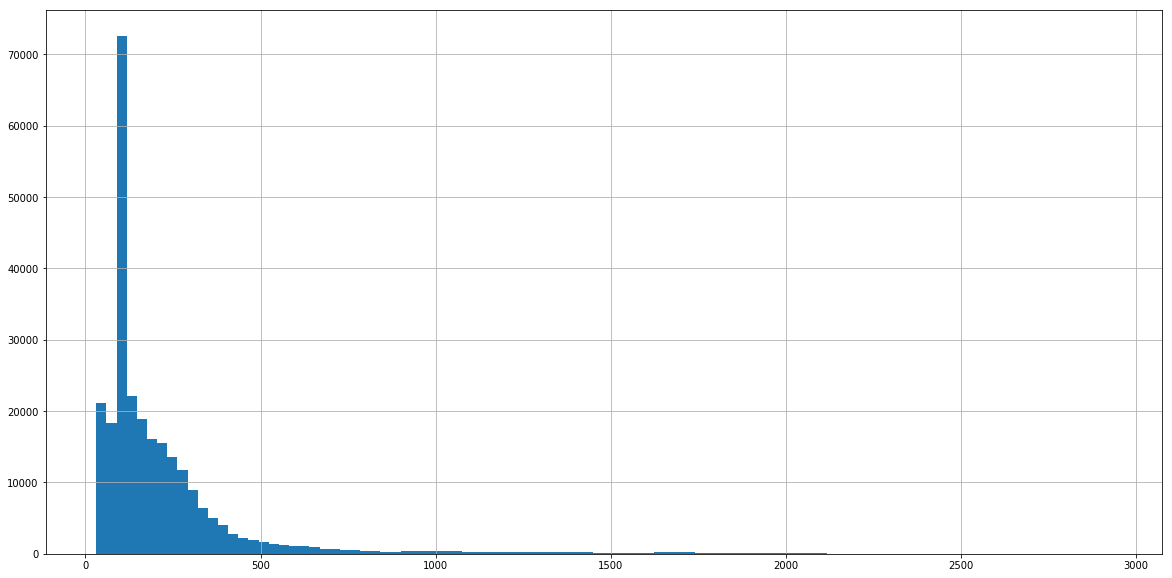

<IPython.core.display.Javascript object>

In [39]:
df.customer_since_days.hist(bins=100, figsize=(20, 10))

In [40]:
df.customer_since_days.value_counts()

92      34790
93       2949
94       2523
31       2339
95       2178
        ...  
2315        1
2509        1
2059        1
1997        1
2122        1
Name: customer_since_days, Length: 2216, dtype: int64

<IPython.core.display.Javascript object>

In [41]:
bins = [0.0, 60, 120, 180, 240, 300, np.inf]
labels = ["0-60", "60-120", "120-180", "180-240", "240-300", "300+"]

<IPython.core.display.Javascript object>

In [42]:
df["customer_since_ranges"] = pd.cut(
    df["customer_since_days"], bins=bins, labels=labels, include_lowest=True
)

<IPython.core.display.Javascript object>

In [43]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,days_since_last_order,rec_segment_0-30,rec_segment_30-60,rec_segment_60-90,rec_segment_90-120,rec_segment_120-180,rec_segment_180+,customer_since_days,customer_since_ranges
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,95,60-120
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,92,0,0,0,1,0,0,92,60-120
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,92,0,0,0,1,0,0,96,60-120
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,92,0,0,0,1,0,0,92,60-120
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,102,0,0,0,1,0,0,103,60-120


<IPython.core.display.Javascript object>

In [44]:
one_hot_cust_since = pd.get_dummies(df["customer_since_ranges"], prefix="cust_since")

<IPython.core.display.Javascript object>

In [45]:
df = df.join(one_hot_cust_since)

<IPython.core.display.Javascript object>

In [46]:
df = df.drop("customer_since_ranges", axis=1)

<IPython.core.display.Javascript object>

In [47]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,...,rec_segment_90-120,rec_segment_120-180,rec_segment_180+,customer_since_days,cust_since_0-60,cust_since_60-120,cust_since_120-180,cust_since_180-240,cust_since_240-300,cust_since_300+
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,...,1,0,0,95,0,1,0,0,0,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,...,1,0,0,92,0,1,0,0,0,0
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,...,1,0,0,96,0,1,0,0,0,0
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,...,1,0,0,92,0,1,0,0,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,...,1,0,0,103,0,1,0,0,0,0


<IPython.core.display.Javascript object>

In [48]:
df = df.drop("rec_segment_180+", axis=1)

<IPython.core.display.Javascript object>

### One hot encode country code

In [49]:
one_hot_country_code = pd.get_dummies(df["country_code"], prefix="country_code")

<IPython.core.display.Javascript object>

In [50]:
df = df.join(one_hot_country_code)

<IPython.core.display.Javascript object>

In [51]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,...,cust_since_0-60,cust_since_60-120,cust_since_120-180,cust_since_180-240,cust_since_240-300,cust_since_300+,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

# Exploratory Data Analysis

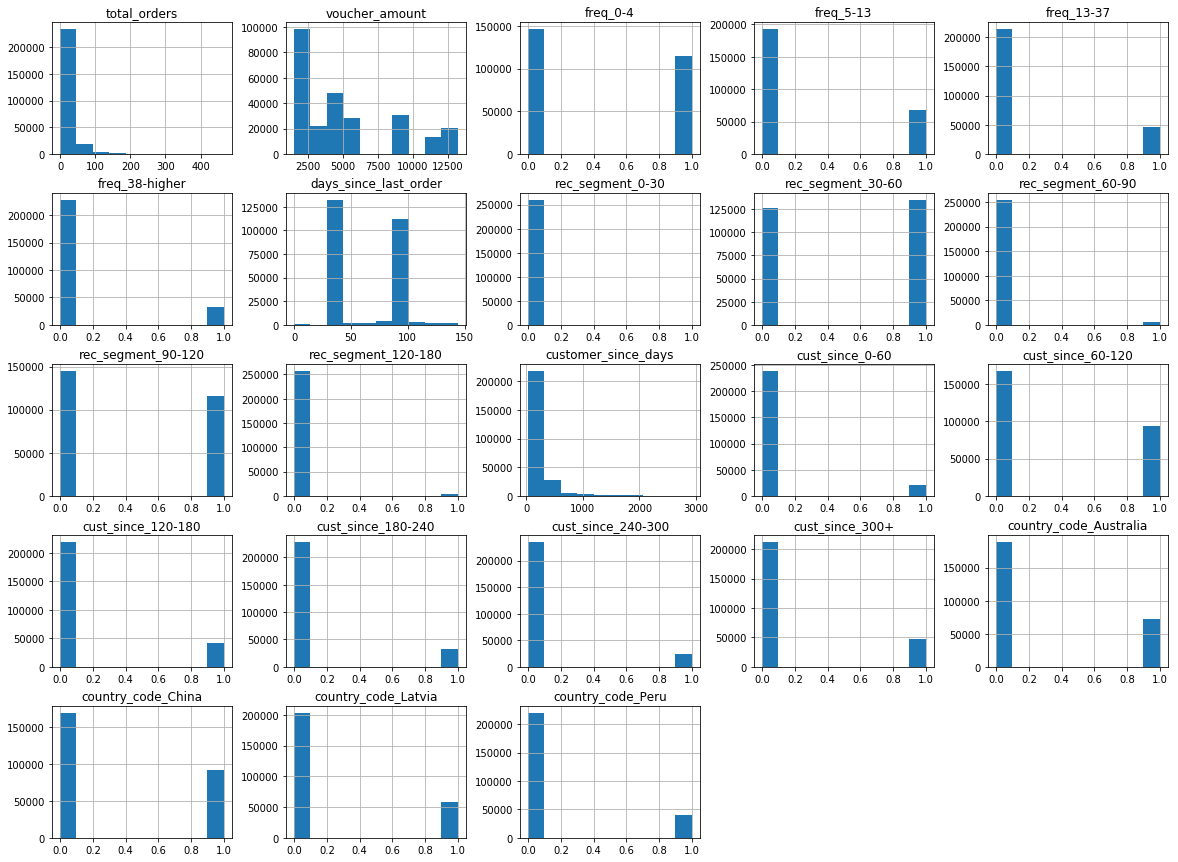

<IPython.core.display.Javascript object>

In [52]:
df.hist(figsize=(20, 15))
plt.show()

In [53]:
df.corr().style.background_gradient(cmap="coolwarm").set_precision(2)

,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,days_since_last_order,rec_segment_0-30,rec_segment_30-60,rec_segment_60-90,rec_segment_90-120,rec_segment_120-180,customer_since_days,cust_since_0-60,cust_since_60-120,cust_since_120-180,cust_since_180-240,cust_since_240-300,cust_since_300+,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru
total_orders,1.00,-0.02,-0.43,-0.16,0.09,0.75,-0.21,0.01,0.20,0.04,-0.21,-0.03,0.39,-0.12,-0.27,-0.04,0.03,0.09,0.36,0.03,-0.05,0.01,0.02
voucher_amount,-0.02,1.00,0.03,-0.01,-0.01,-0.02,0.12,-0.00,-0.12,-0.01,0.13,0.02,-0.01,-0.07,0.06,-0.01,0.01,0.00,-0.02,-0.01,-0.20,0.44,-0.22
freq_0-4,-0.43,0.03,1.00,-0.52,-0.41,-0.33,0.32,-0.02,-0.32,-0.06,0.33,0.05,-0.31,0.15,0.39,-0.07,-0.14,-0.16,-0.29,-0.08,0.09,-0.01,-0.00
freq_5-13,-0.16,-0.01,-0.52,1.00,-0.28,-0.22,-0.08,0.01,0.07,0.01,-0.08,-0.01,-0.03,0.01,-0.09,0.08,0.05,0.02,-0.04,0.02,-0.02,0.01,-0.01
freq_13-37,0.09,-0.01,-0.41,-0.28,1.00,-0.18,-0.18,0.01,0.17,0.03,-0.18,-0.02,0.14,-0.11,-0.20,0.03,0.09,0.10,0.14,0.06,-0.06,0.01,0.00
freq_38-higher,0.75,-0.02,-0.33,-0.22,-0.18,1.00,-0.18,0.01,0.18,0.03,-0.19,-0.02,0.33,-0.11,-0.24,-0.05,0.03,0.09,0.32,0.03,-0.04,-0.00,0.01
days_since_last_order,-0.21,0.12,0.32,-0.08,-0.18,-0.18,1.00,-0.09,-0.97,0.07,0.91,0.26,-0.06,-0.28,0.27,0.03,-0.05,-0.05,-0.08,-0.13,-0.08,0.18,0.06
rec_segment_0-30,0.01,-0.00,-0.02,0.01,0.01,0.01,-0.09,1.00,-0.05,-0.01,-0.04,-0.01,0.00,0.00,-0.02,0.00,0.01,0.01,0.00,0.04,-0.01,-0.02,-0.01
rec_segment_30-60,0.20,-0.12,-0.32,0.07,0.17,0.18,-0.97,-0.05,1.00,-0.16,-0.92,-0.12,0.06,0.29,-0.28,-0.01,0.05,0.05,0.08,0.13,0.09,-0.18,-0.07
rec_segment_60-90,0.04,-0.01,-0.06,0.01,0.03,0.03,0.07,-0.01,-0.16,1.00,-0.14,-0.02,0.04,-0.05,-0.04,0.02,0.01,0.02,0.04,-0.02,0.00,0.01,0.02


<IPython.core.display.Javascript object>

In [54]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,...,cust_since_0-60,cust_since_60-120,cust_since_120-180,cust_since_180-240,cust_since_240-300,cust_since_300+,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

## Create most commonly used voucher column

In [55]:
df.columns

Index(['timestamp', 'country_code', 'last_order_ts', 'first_order_ts',
       'total_orders', 'voucher_amount', 'freq_0-4', 'freq_5-13', 'freq_13-37',
       'freq_38-higher', 'days_since_last_order', 'rec_segment_0-30',
       'rec_segment_30-60', 'rec_segment_60-90', 'rec_segment_90-120',
       'rec_segment_120-180', 'customer_since_days', 'cust_since_0-60',
       'cust_since_60-120', 'cust_since_120-180', 'cust_since_180-240',
       'cust_since_240-300', 'cust_since_300+', 'country_code_Australia',
       'country_code_China', 'country_code_Latvia', 'country_code_Peru'],
      dtype='object')

<IPython.core.display.Javascript object>

In [56]:
df_frequent_segment = df[
    [
        "timestamp",
        "country_code",
        "last_order_ts",
        "first_order_ts",
        "total_orders",
        "voucher_amount",
        "freq_0-4",
        "freq_5-13",
        "freq_13-37",
        "freq_38-higher",
        #         "customer_since_days",
        #         "cust_since_0-60",
        #         "cust_since_60-120",
        #         "cust_since_120-180",
        #         "cust_since_180-240",
        #         "cust_since_240-300",
        #         "cust_since_300+",
        "country_code_Australia",
        "country_code_China",
        "country_code_Latvia",
        "country_code_Peru",
    ]
]

<IPython.core.display.Javascript object>

In [57]:
df_recency_segment = df[
    [
        "timestamp",
        "country_code",
        "last_order_ts",
        "first_order_ts",
        "voucher_amount",
        "days_since_last_order",
        "rec_segment_0-30",
        "rec_segment_30-60",
        "rec_segment_60-90",
        "rec_segment_90-120",
        "rec_segment_120-180",
        #         "customer_since_days",
        #         "cust_since_0-60",
        #         "cust_since_60-120",
        #         "cust_since_120-180",
        #         "cust_since_180-240",
        #         "cust_since_240-300",
        #         "cust_since_300+",
        "country_code_Australia",
        "country_code_China",
        "country_code_Latvia",
        "country_code_Peru",
    ]
]

<IPython.core.display.Javascript object>

In [58]:
df_frequent_most_used = (
    df_frequent_segment.groupby(
        ["country_code", "freq_0-4", "freq_5-13", "freq_13-37", "freq_38-higher"]
    )["voucher_amount"]
    .apply(lambda x: x.value_counts().index[0])
    .reset_index()
)

<IPython.core.display.Javascript object>

In [59]:
df_reecency_most_used = (
    df_recency_segment.groupby(
        [
            "country_code",
            "rec_segment_0-30",
            "rec_segment_30-60",
            "rec_segment_60-90",
            "rec_segment_90-120",
            "rec_segment_120-180",
        ]
    )["voucher_amount"]
    .apply(lambda x: x.value_counts().index[0])
    .reset_index()
)

<IPython.core.display.Javascript object>

In [60]:
def apply_most_recently_used(row: dict) -> int:

    #     print("DBG_TRC:", row)

    segment = None
    for k, v in row.items():
        if v == 1:
            segment = k

    if not segment:
        print("No valid segment found")
        return -1

    return df_reecency_most_used[
        (row["country_code"] == df_reecency_most_used.country_code)
        & (df_reecency_most_used[segment] == 1)
    ]["voucher_amount"].to_numpy()[0]

<IPython.core.display.Javascript object>

In [67]:
def apply_most_frequently_used(row: dict) -> int:

    segment = None
    for k, v in row.items():
        if v == 1:
            segment = k

    if not segment:
        print("No valid segment found")
        return -1

    return df_frequent_most_used[
        (row["country_code"] == df_frequent_most_used.country_code)
        & (df_frequent_most_used[segment] == 1)
    ]["voucher_amount"].to_numpy()[0]

<IPython.core.display.Javascript object>

In [62]:
df_recency_segment["most_common_voucher"] = df_recency_segment[
    [
        "country_code",
        "rec_segment_0-30",
        "rec_segment_30-60",
        "rec_segment_60-90",
        "rec_segment_90-120",
        "rec_segment_120-180",
        "voucher_amount",
    ]
].parallel_apply(lambda x: apply_most_recently_used(x), axis=1)

/home/rahul/Personal/Tech/GitHub/CustomerReactivation/venv_cust/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>

In [63]:
df_recency_segment.head()

,timestamp,country_code,last_order_ts,first_order_ts,voucher_amount,days_since_last_order,rec_segment_0-30,rec_segment_30-60,rec_segment_60-90,rec_segment_90-120,rec_segment_120-180,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru,most_common_voucher
0,2018-07-21,Latvia,2018-04-20,2018-04-17,4400.0,92,0,0,0,1,0,0,0,1,0,13200.0
1,2018-07-21,Peru,2018-04-20,2018-04-20,4400.0,92,0,0,0,1,0,0,0,0,1,2640.0
2,2018-07-21,Peru,2018-04-20,2018-04-16,2640.0,92,0,0,0,1,0,0,0,0,1,2640.0
3,2018-07-21,China,2018-04-20,2018-04-20,3080.0,92,0,0,0,1,0,0,1,0,0,1760.0
4,2018-07-31,Peru,2018-04-20,2018-04-19,4400.0,102,0,0,0,1,0,0,0,0,1,2640.0


<IPython.core.display.Javascript object>

In [65]:
df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,...,cust_since_0-60,cust_since_60-120,cust_since_120-180,cust_since_180-240,cust_since_240-300,cust_since_300+,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [64]:
df_frequent_segment.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount,freq_0-4,freq_5-13,freq_13-37,freq_38-higher,country_code_Australia,country_code_China,country_code_Latvia,country_code_Peru
0,2018-07-21,Latvia,2018-04-20,2018-04-17,0.0,4400.0,1,0,0,0,0,0,1,0
1,2018-07-21,Peru,2018-04-20,2018-04-20,0.0,4400.0,1,0,0,0,0,0,0,1
2,2018-07-21,Peru,2018-04-20,2018-04-16,1.0,2640.0,1,0,0,0,0,0,0,1
3,2018-07-21,China,2018-04-20,2018-04-20,2.0,3080.0,1,0,0,0,0,1,0,0
4,2018-07-31,Peru,2018-04-20,2018-04-19,0.0,4400.0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [68]:
df_frequent_segment["most_common_voucher"] = df_frequent_segment[
    [
        "country_code",
        "freq_0-4",
        "freq_5-13",
        "freq_13-37",
        "freq_38-higher",
        "voucher_amount",
    ]
].parallel_apply(lambda x: apply_most_frequently_used(x), axis=1)

/home/rahul/Personal/Tech/GitHub/CustomerReactivation/venv_cust/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

In [71]:
df_frequent_segment.to_csv("../data/frequent_segment_dataset.csv")

<IPython.core.display.Javascript object>

In [72]:
df_recency_segment.to_csv("../data/recency_segment_dataset.csv")

<IPython.core.display.Javascript object>

## Split Train and Test Set

In [116]:
def get_train_test_set(df):
    train, test = train_test_split(
        df, test_size=0.2, random_state=0, stratify=df[["country_code"]],
    )

    return train, test

<IPython.core.display.Javascript object>

# Train model for Frequent Segment

In [117]:
train, test = get_train_test_set(df_frequent_segment)

<IPython.core.display.Javascript object>

In [118]:
FREQUENT_SEGMENT_COLUMNS_TO_TRAIN = [
    "freq_0-4",
    "freq_5-13",
    "freq_13-37",
    "freq_38-higher",
    "country_code_Australia",
    "country_code_China",
    "country_code_Latvia",
    "country_code_Peru",
]

TARGET_COLUMN = ["most_common_voucher"]

<IPython.core.display.Javascript object>

In [119]:
train, test = get_train_test_set(df_frequent_segment)

<IPython.core.display.Javascript object>

In [120]:
X_train, Y_train = (
    train[FREQUENT_SEGMENT_COLUMNS_TO_TRAIN],
    train[TARGET_COLUMN],
)

<IPython.core.display.Javascript object>

In [121]:
X_test, Y_test = (
    test[FREQUENT_SEGMENT_COLUMNS_TO_TRAIN],
    test[TARGET_COLUMN],
)

<IPython.core.display.Javascript object>

# Train Model

In [122]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

<IPython.core.display.Javascript object>

In [123]:
freq_segment_model = xgb.XGBClassifier(
    learning_rate=0.001,
    max_depth=10,
    n_estimators=100,
    eval_metric=["merror"],
    eval_set=eval_set,
    early_stopping_rounds=50,
)

<IPython.core.display.Javascript object>

In [124]:
freq_segment_model.fit(X_train, Y_train)

/home/rahul/Personal/Tech/GitHub/CustomerReactivation/venv_cust/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[18:00:28] WARNING: xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              eval_metric=['merror'],
              eval_set=[(        freq_0-4  freq_5-13  freq_13-37  freq_38-higher  \
239285         1          0           0               0   
63614          1          0           0               0   
198014         1          0           0               0   
278549         1          0           0               0   
768            1          0           0               0   
...          ...        ...         ...             ...   
174046         0          0           1               0   
40713          1          0           0               0   
110477         0          0           1               0   
199906         1          0           0               0   
69674          0          0           1               0   

        country_code_Australia  country_code_C...
              gamma=0, gpu_id

<IPython.core.display.Javascript object>

In [125]:
frequest_segment_pred = freq_segment_model.predict(X_test)

<IPython.core.display.Javascript object>

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

<IPython.core.display.Javascript object>

In [126]:
print(classification_report(Y_test, frequest_segment_pred))

              precision    recall  f1-score   support

      1760.0       1.00      1.00      1.00     18288
      2200.0       1.00      1.00      1.00      9252
      2640.0       1.00      1.00      1.00      8127
      4400.0       1.00      1.00      1.00      6529
      5720.0       1.00      1.00      1.00      5072
     13200.0       1.00      1.00      1.00      4958

    accuracy                           1.00     52226
   macro avg       1.00      1.00      1.00     52226
weighted avg       1.00      1.00      1.00     52226



<IPython.core.display.Javascript object>

# Train model for Recency Segment

In [127]:
train, test = get_train_test_set(df_recency_segment)

<IPython.core.display.Javascript object>

In [128]:
RECENCY_SEGMENT_COLUMNS_TO_TRAIN = [
    "rec_segment_0-30",
    "rec_segment_30-60",
    "rec_segment_60-90",
    "rec_segment_90-120",
    "rec_segment_120-180",
    "country_code_Australia",
    "country_code_China",
    "country_code_Latvia",
    "country_code_Peru",
]

TARGET_COLUMN = ["most_common_voucher"]

<IPython.core.display.Javascript object>

In [129]:
X_train, Y_train = (
    train[RECENCY_SEGMENT_COLUMNS_TO_TRAIN],
    train[TARGET_COLUMN],
)

<IPython.core.display.Javascript object>

In [130]:
X_test, Y_test = (
    test[RECENCY_SEGMENT_COLUMNS_TO_TRAIN],
    test[TARGET_COLUMN],
)

<IPython.core.display.Javascript object>

# Train Model

In [131]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

<IPython.core.display.Javascript object>

In [132]:
recency_segment_model = xgb.XGBClassifier(
    learning_rate=0.001,
    max_depth=10,
    n_estimators=100,
    eval_metric=["merror"],
    eval_set=eval_set,
    early_stopping_rounds=50,
)

<IPython.core.display.Javascript object>

In [133]:
recency_segment_model.fit(X_train, Y_train)

/home/rahul/Personal/Tech/GitHub/CustomerReactivation/venv_cust/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[18:01:34] WARNING: xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              eval_metric=['merror'],
              eval_set=[(        rec_segment_0-30  rec_segment_30-60  rec_segment_60-90  \
239285                 0                  0                  0   
63614                  0                  0                  0   
198014                 0                  0                  0   
278549                 0                  1                  0   
768                    0                  0                  0   
...                  ...                ...                ...   
174046                 0                  1                  0   
40713                  0                  1                  0   
110477                 0                  0                  1   
199906                 0                  0                  0   
69674                  0                  1                  0

<IPython.core.display.Javascript object>

In [134]:
recency_segment_predict = recency_segment_model.predict(X_test)

<IPython.core.display.Javascript object>

In [135]:
print(classification_report(Y_test, recency_segment_predict))

              precision    recall  f1-score   support

      1760.0       1.00      1.00      1.00     18288
      2200.0       1.00      1.00      1.00     14237
      2640.0       1.00      1.00      1.00      8127
      4400.0       1.00      1.00      1.00      4213
      5720.0       1.00      1.00      1.00        87
     13200.0       1.00      1.00      1.00      7274

    accuracy                           1.00     52226
   macro avg       1.00      1.00      1.00     52226
weighted avg       1.00      1.00      1.00     52226



<IPython.core.display.Javascript object>

# Peru only Model

from sklearn.metrics import classification_report, confusion_matrix

df_peru = df[df.country_code == "Peru"]

df_peru.voucher_amount.unique()

voucher_to_label = {4400.0: 1, 2640.0: 2, 3520.0: 3}
label_to_voucher = {1: 4400.0, 2: 2640.0, 3: 3520.0}

def convert_voucher_to_label(voucher: float):
    return voucher_to_label[voucher]

df_peru["voucher_label"] = df_peru.voucher_amount.apply(
    lambda x: convert_voucher_to_label(x)
)

train, test = train_test_split(
    df_peru, test_size=0.2, random_state=0, stratify=df_peru[["voucher_label"]]
)

COLUMNS_TO_TRAIN_PERU = [
    "total_orders",
    "days_since_last_order",
    "customer_since_days",
    "freq_0-4",
    "freq_5-13",
    "freq_13-37",
    "freq_38-higher",
    "rec_segment_0-30",
    "rec_segment_30-60",
    "rec_segment_60-90",
    "rec_segment_90-120",
    "rec_segment_120-180",
    "cust_since_0-60",
    "cust_since_60-120",
    "cust_since_120-180",
    "cust_since_180-240",
    "cust_since_240-300",
    "cust_since_300+",
]

TARGET_COLUMN = ["voucher_label"]

X_train, Y_train = train[COLUMNS_TO_TRAIN_PERU], train[TARGET_COLUMN]
X_test, Y_test = test[COLUMNS_TO_TRAIN_PERU], test[TARGET_COLUMN]

xgb_model = xgb.XGBClassifier(learning_rate=0.01, max_depth=1, n_estimators=500)

xgb_model.fit(X_train, Y_train)

xgb_predict_peru = xgb_model.predict(X_test)

print(classification_report(Y_test, xgb_predict_peru))

xgb_predict_peru

df_peru.corr()["voucher_amount"].to_frame().style.background_gradient(
    cmap="coolwarm"
).set_precision(2)

## Train only on original features

ORIGINAL_COLUMNS_TO_TRAIN_PERU = [
    "total_orders",
    "days_since_last_order",
    "customer_since_days",
]

TARGET_COLUMN = ["voucher_label"]

train, test = train_test_split(
    df_peru,
    test_size=0.2,
    random_state=0
    #     , stratify=df_peru[["voucher_label"]]
)

X_train, Y_train = train[COLUMNS_TO_TRAIN_PERU], train[TARGET_COLUMN]
X_test, Y_test = test[COLUMNS_TO_TRAIN_PERU], test[TARGET_COLUMN]

xgb_model = xgb.XGBClassifier(
    learning_rate=0.001,
    max_depth=20,
    n_estimators=500,
    objective="multi:softprob",
    random_state=42,
)

eval_set = [(X_train, Y_train), (X_test, Y_test)]

xgb_model.fit(
    X_train,
    Y_train,
    eval_metric=["merror"],
    eval_set=eval_set,
    early_stopping_rounds=50
    #     verbose=True,
)

xgb_predict_peru = xgb_model.predict(X_test)

print(classification_report(Y_test, xgb_predict_peru))

xgb_predict_peru[:20]

Y_test[:20].values

## Random Forest

from sklearn.ensemble import RandomForestClassifier


train, test = train_test_split(
    df_peru, test_size=0.1, random_state=0, stratify=df_peru[["voucher_label"]]
)

X_train, Y_train = train[COLUMNS_TO_TRAIN_PERU], train[TARGET_COLUMN]
X_test, Y_test = test[COLUMNS_TO_TRAIN_PERU], test[TARGET_COLUMN]

rnd_clf = RandomForestClassifier(
    random_state=0, n_estimators=500, bootstrap=True, max_features="sqrt"
)

rnd_clf.fit(X_train, Y_train)

xgb_predict_peru = rnd_clf.predict(X_test)

print(classification_report(Y_test, xgb_predict_peru))

xgb_predict_peru[:20]

Y_test[:20].values

## Scale inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

X_test_scaled = scaler.transform(X_test.astype(np.float64))

rnd_clf = RandomForestClassifier(
    random_state=0, n_estimators=500, bootstrap=True, max_features="sqrt", n_jobs=8
)

rnd_clf.fit(X_train_scaled, Y_train)

xgb_predict_peru = rnd_clf.predict(X_test_scaled)

print(classification_report(Y_test, xgb_predict_peru))

xgb_predict_peru[-20:]

Y_test[-20:].values

## Debug

df_peru.head()

df_peru[df_peru["freq_0-4"] == 1]["voucher_amount"].value_counts()